## Etap 5 - Zbieranie danych i weryfikacja wyników
* Pozyskanie ground truth z YouTube API (spójnego z ustaloną charakterystyką
danych)
* Weryfikacja wyników w oparciu o porównanie uzyskanych wyników z tzw. ground
truth
* Skorzystanie z YouTube API aby pozyskać dane nie-trending
* Dane powinny być kompatybilne z naszymi trending - generalnie ten sam okres,
równie popularne, zgodność atrybutów, itd.
* Oczyszczenie i zintegrowanie danych non-trending
* Odfiltrowanie nieinteresujących nas kategorii
* Ewentualne zweryfikowanie ważności atrybutów wybranych we wcześniejszym
etapie  


* OCENA (15%)
  * 5% ground truth + weryfikacja wyników z semi-supervised learning
  * 6% zgromadzenie odpowiednich danych kontrastujących z trending
  * 4% przygotowanie danych non-trending, odfiltrowanie niektórych kategorii

The following files are needed to run the code:
* _data_checkpoint4.csv_
* _data_c12.hdf_
* _categories_gt.csv_
* _bestLogReg.joblib_
* _data_checkpoint5.csv_


## Constants

In [0]:
DATA_FILE = 'data_checkpoint4.csv'
DATA_OLD = 'data_c12.hdf'
DATA_GT = 'categories_gt.csv'
DATA_NT = 'data_checkpoint5.csv'
CLASSIFIER = 'bestLogReg.joblib'
RANDOM_STATE = 1996

In [0]:
!pip install --upgrade tables
!pip install langdetect

In [0]:
from google.colab import drive # Google Drive connection
from joblib import Memory # Memmory cache

# Pandas
import pandas as pd
# progress_apply
from tqdm.auto import tqdm  
tqdm.pandas()

from os import cpu_count
from os import path # joinging path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style 
import seaborn as sns
import langdetect

# Scikit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ParameterGrid
from copy import deepcopy
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import f1_score

# loading model
from joblib import load

# disable warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Google Drive

In [0]:
# Mount google drive and load data
drive.mount('/content/drive')

drive_path = "/content/drive/My Drive/"
data_path = path.join(drive_path , 'datasets/youtube_data')
image_path = path.join(data_path, 'images')
cache_path = path.join(drive_path, 'cache')

# Set cache
memory = Memory(location=cache_path, verbose=0)

## Loading files

In [0]:
df = pd.read_csv(path.join(data_path, DATA_FILE))
df_old = pd.read_hdf(path.join(data_path, DATA_OLD))
ground_truth = pd.read_csv(path.join(data_path, DATA_GT), sep=";")
clf = load(path.join(data_path, CLASSIFIER))

## Retrieving ground-truth

In [0]:
def find_cat(x):
  cat = ground_truth[ground_truth.video_id == x].category_id.values
  if len(cat) == 0:
    return None
  if len(cat) == 1:
    return cat[0]
  else:
    raise ValueError("More than one category matching")

df_old["true_cat"] = df_old.video_id.apply(find_cat)
mapping = df_old[["video_id", "true_cat"]]

In [0]:
X = df.drop(columns=['category_id']).to_numpy()
y_true = mapping.loc[:,'true_cat'].to_numpy()

In [0]:
sum(np.isnan(y_true))

674

Some videos in ground truth are missing cattegory. We will remove them.

In [0]:
to_remove = np.where(np.isnan(y_true))
X = np.delete(X, to_remove, axis=0)
y_true = np.delete(y_true, to_remove)

In [0]:
print(X.shape)
print(y_true.shape)

(7932, 914)
(7932,)


## Prediction verification with ground-truth

In [0]:
from sklearn.metrics import f1_score, accuracy_score
y_pred = clf.predict(X)
result = f1_score(y_true, y_pred, zero_division=1, average="weighted")*100
print("Weighted F1-Score = %.2f%%" % result)

Weighted F1-Score = 47.75%


We've achieved a _Weighted F1-score_ equal to **47.75%**.  
The value is lover than the one we reported on the _test set_: **54%**. We should consider changing _train-validation-test split_ into _cross-validation_ in reitarations.

## Non-trending data aquisition

Due to the fact, that YouTube Data API is not faultless, we acquired non-trending data in the following way:
 * considered publish time: 14.11.2017 - 14.06.2018
 * the timespace was divided into 7-days pieces
 * relevance language set to English
 * request for most popular videos (argument: order='viewCount) made for each timepiece and every category present in trending data

Following quieries were made to obtain needed data:

```
# to obtain video ids
youtube.search().list(part='snippet',
                      maxResults=50,
                      publishedAfter=start_times[i],
                      publishedBefore=end_times[i],
                      order='viewCount',
                      type='video',
                      relevanceLanguage='en',
                      videoCategoryId=cat_id
                      pageToken=page_token).execute()
```

```
# to obtain video statistics
youtube.videos().list(part='statistics', id=video_id).execute()
```

In [0]:
df = pd.read_csv(path.join(data_path, DATA_NT), sep=";")

In [0]:
df.head()

,videoId,publishedAt,title,description,thumbnail,channelTitle,liveBcast,tags,categoryId,views,likes,dislikes,commentCount
0,TyHvyGVs42U,2017-11-17T05:00:01.000Z,"Luis Fonsi, Demi Lovato - Échame La Culpa (Vid...",Échame La Culpa” disponible ya en todas las pl...,https://i.ytimg.com/vi/TyHvyGVs42U/default.jpg,LuisFonsiVEVO,none,"['luis fonsi', 'luis fonsi vevo', 'luis fonsi ...",10.0,1.988121e+09,8547948.0,663220.0,327170.0
1,YXSFMV8JOF4,2017-11-17T13:00:03.000Z,Gustavo Mioto - Anti-Amor Part Jorge e Mateus,Quer ter acesso em primeira mão ao novo álbum ...,https://i.ytimg.com/vi/YXSFMV8JOF4/default.jpg,Gustavo Mioto,none,"['gustavo mioto', 'jorge e mateus', 'dvd', 'no...",10.0,4.757330e+08,1614753.0,83443.0,20456.0
2,T4dusvA1fi0,2017-11-18T12:00:01.000Z,Juguemos en el Bosque - La Granja de Zenón 4 |...,Suscríbete ▻ http://bit.ly/SuscribeteElReinoIn...,https://i.ytimg.com/vi/T4dusvA1fi0/default.jpg,El Reino Infantil,none,"['El Reino Infantil', 'El Reino', 'canciones',...",10.0,2.597699e+08,404733.0,256359.0,1845.0
3,6uJf2IT2Zh8,2017-11-17T09:00:03.000Z,Red Velvet 레드벨벳 &#39;피카부 (Peek-A-Boo)&#39; MV,"Red Velvet's 2nd full length album ""Perfect Ve...",https://i.ytimg.com/vi/6uJf2IT2Zh8/default.jpg,SMTOWN,none,"['Red Velvet', '레드벨벳', '피카부', 'PeekABoo', 'Pee...",10.0,1.675386e+08,2020658.0,53720.0,122379.0
4,UuCq8mtK8J4,2017-11-16T05:00:01.000Z,"DJ Snake, Lauv - A Different Way (Official Video)","Listen to DJ Snake's 'A Different Way,' out no...",https://i.ytimg.com/vi/UuCq8mtK8J4/default.jpg,DJSnakeVEVO,none,"['DJ Snake', 'Lauv', 'A Different Way', 'Arc D...",10.0,1.514931e+08,1280205.0,32207.0,22809.0


In [0]:
len(df)

58876

Firstly, we will filter out videos, which appeared on trending lists

In [0]:
df_trending = pd.read_hdf(path.join(data_path, DATA_OLD))
trending_ids = set(df_trending['video_id'])

In [0]:
df = df[~df.videoId.isin(trending_ids)]

In [0]:
len(df)

57591

Next, we will make sure that data fits in time bounds.

In [0]:
import datetime
import pytz
df['publishedAt'] = pd.to_datetime(df.publishedAt)
df = df[df.publishedAt < datetime.datetime(2018, 6, 15, tzinfo=pytz.utc) ]

In [0]:
len(df)

56594

We will delete incomplete data - rows with empty views count

In [0]:
df = df[~df.views.isna()]

In [0]:
len(df)

55734

The next step is deleting rows with views count lower than lower bound of views count in trending data

In [0]:
df = df[df.views>=min(list(df_trending['views']))]

In [0]:
len(df)

53973

YouTube Data API is not ideal. In spite of getting only videos with relevance language set to English, there are a lot of videos, which actually don't have any word in title or description written in Eglish. We will filter out those films based on language detected in title

In [0]:
from langdetect import lang_detect_exception
def detect_lang(text):
  try:
    lang = langdetect.detect(text)
  except:
    lang = None
  return lang

In [0]:
df['language'] = df.apply(lambda row: detect_lang(row['title']), axis=1)

In [0]:
df[df.language!='en'].head(5)

,videoId,publishedAt,title,description,thumbnail,channelTitle,liveBcast,tags,categoryId,views,likes,dislikes,commentCount,language
1,YXSFMV8JOF4,2017-11-17 13:00:03+00:00,Gustavo Mioto - Anti-Amor Part Jorge e Mateus,Quer ter acesso em primeira mão ao novo álbum ...,https://i.ytimg.com/vi/YXSFMV8JOF4/default.jpg,Gustavo Mioto,none,"['gustavo mioto', 'jorge e mateus', 'dvd', 'no...",10.0,475733001.0,1614753.0,83443.0,20456.0,it
2,T4dusvA1fi0,2017-11-18 12:00:01+00:00,Juguemos en el Bosque - La Granja de Zenón 4 |...,Suscríbete ▻ http://bit.ly/SuscribeteElReinoIn...,https://i.ytimg.com/vi/T4dusvA1fi0/default.jpg,El Reino Infantil,none,"['El Reino Infantil', 'El Reino', 'canciones',...",10.0,259769911.0,404733.0,256359.0,1845.0,es
6,xb06CqeSgCQ,2017-11-15 14:04:25+00:00,Saif Nabeel And Asraa Alasil - Abe Ashof (Offi...,Saif Nabeel And Asraa Alasil - Abe Ashof (Offi...,https://i.ytimg.com/vi/xb06CqeSgCQ/default.jpg,الـريماس - Al-Remas,none,"['سيف نبيل واسراء الاصيل', 'اسراء الاصيل', 'سي...",10.0,99079339.0,673905.0,37839.0,52840.0,so
8,dq6G2YWoRqA,2017-11-15 12:07:54+00:00,OrelSan - Tout va bien [CLIP OFFICIEL],La fête est finie : https://orelsan.lnk.to/LaF...,https://i.ytimg.com/vi/dq6G2YWoRqA/default.jpg,orelsan,none,[],10.0,38113520.0,406354.0,12387.0,17987.0,nl
10,9cpR2Vs0j90,2017-11-18 12:00:02+00:00,Familia Dedo de Colores #1 ♫ Plim Plim ♫ Canci...,SUSCRIBETE AQUI! ▻ http://goo.gl/HKuo86 Produc...,https://i.ytimg.com/vi/9cpR2Vs0j90/default.jpg,El Payaso Plim Plim,none,"['plim plim', 'el payaso plim plim', 'plin pli...",10.0,28429994.0,58488.0,36193.0,200.0,es


In [0]:
df = df[df.language=='en']
len(df)

39812

Some videos are live broadcasts - we don't want to consider them

In [0]:
df = df[df.liveBcast=='none']

In [0]:
len(df)

39808

We can now delete this column, as well as 'language' column

In [0]:
df = df.drop(['liveBcast', 'language'], axis=1)

In [0]:
df.sort_values(by='views', ascending=False).head()

,videoId,publishedAt,title,description,thumbnail,channelTitle,tags,categoryId,views,likes,dislikes,commentCount
43095,020g-0hhCAU,2017-11-21 08:00:01+00:00,Baby Shark | CoComelon Nursery Rhymes &amp; Ki...,Subscribe for new videos every week: https://w...,https://i.ytimg.com/vi/020g-0hhCAU/default.jpg,Cocomelon - Nursery Rhymes,"['abckidtv', 'cocomelon', 'kid songs', 'sing-a...",27.0,1.235668e+09,2489331.0,1547717.0,118.0
44722,1GDFa-nEzlg,2018-02-22 15:30:01+00:00,This Is The Way We Get Dressed | Kids Songs | ...,Check out the Super Simple App for iOS! ▻ http...,https://i.ytimg.com/vi/1GDFa-nEzlg/default.jpg,Super Simple Songs - Kids Songs,"['kids songs', 'this is the way', 'this is the...",27.0,7.316545e+08,1962258.0,1228569.0,3955.0
2837,mfJhMfOPWdE,2018-05-18 12:28:39+00:00,Armin van Buuren - Blah Blah Blah (Official Ly...,My new single 'All On Me' is OUT NOW ▷ https:/...,https://i.ytimg.com/vi/mfJhMfOPWdE/default.jpg,Armin van Buuren,"['Blah', 'Blah Blah', 'Blah Blah Blah', 'Armin...",10.0,4.319719e+08,3319298.0,128450.0,72739.0
3025,fOrPSLkuI54,2018-05-30 18:32:55+00:00,Wesley Safadão e Aldair Playboy ft. Kevinho - ...,Novo single do Wesley Safadão e Aldair Playboy...,https://i.ytimg.com/vi/fOrPSLkuI54/default.jpg,Wesley Safadão,"['Som Livre (Record Label)', 'Forró (Musical G...",10.0,3.777448e+08,2299756.0,165746.0,63177.0
43226,ubmiT8JKeRU,2017-12-01 23:00:08+00:00,Monkey Banana Dance | Baby Monkey | Dance Alon...,Subscribe and watch new videos uploaded every ...,https://i.ytimg.com/vi/ubmiT8JKeRU/default.jpg,Pinkfong! Kids' Songs & Stories,"['pinkfong', 'family', 'kids', 'children', 'to...",27.0,2.906882e+08,703322.0,312424.0,0.0


Values corresponding to video_error_or_removed, comments_disabled and ratings_disabled were not directly accessible - we will assume, that video_error_or_removed is equal to False for every video and comments_disabled and ratings_disabled will be equal to True if comment count or sum of likes and dislikes is equal to 0, respectively. We are aware, that this solution is not perfect, but it seems to be the best approach to this kind of data.

In [0]:
df['video_error_or_removed'] = df.apply(lambda row: False, axis=1)

In [0]:
df['comments_disabled'] = df.apply(lambda row: True if row.commentCount==0 else False, axis=1)

In [0]:
df['ratings_disabled'] = df.apply(lambda row: True if row.likes + row.dislikes == 0 else False, axis=1)

In [0]:
df.head()

,videoId,publishedAt,title,description,thumbnail,channelTitle,tags,categoryId,views,likes,dislikes,commentCount,video_error_or_removed,comments_disabled,ratings_disabled
5,BZT8jqsc8lQ,2017-11-17 05:00:00+00:00,Tasha Cobbs Leonard - Your Spirit ft. Kierra S...,Official Music Video for “Your Spirit” by Tash...,https://i.ytimg.com/vi/BZT8jqsc8lQ/default.jpg,TashaCobbsVEVO,"['Tasha', 'Cobbs', 'Leonard', 'Your Spirit', '...",10.0,115497808.0,520146.0,32952.0,19636.0,False,False,False
7,QuSEbo03fc4,2017-11-14 22:04:50+00:00,"Becky G, Bad Bunny - Mayores (2017 Latin Ameri...","Music video by Becky G, Bad Bunny performing M...",https://i.ytimg.com/vi/QuSEbo03fc4/default.jpg,BeckyGVEVO,"['Becky G & Bad Bunny', 'Kemosabe Records/RCA ...",10.0,49855324.0,309320.0,23742.0,10623.0,False,False,False
12,oOlmtJRB8oI,2017-11-17 08:06:16+00:00,Avicii ft. Rita Ora - Lonely Together (Alan Wa...,"My new single ""Alone, Pt. II"" with Ava Max is ...",https://i.ytimg.com/vi/oOlmtJRB8oI/default.jpg,Alan Walker,"['Alan Walker', 'DJ Walkzz', 'K-391', 'House',...",10.0,24447771.0,303812.0,5106.0,11839.0,False,False,False
14,JPp-oLkQPQQ,2017-11-17 05:00:01+00:00,Sia - Everyday Is Christmas,"Everyday Is Christmas"" from 'Everyday Is Chris...",https://i.ytimg.com/vi/JPp-oLkQPQQ/default.jpg,SiaVEVO,['Sia Everyday Is Christmas Holiday'],10.0,16636599.0,124737.0,2552.0,3115.0,False,False,False
16,tMui4IVW0BM,2017-11-15 08:00:03+00:00,Scorpions - Follow Your Heart (Official Lyric ...,"The brand new album ""Born To Touch Your Feelin...",https://i.ytimg.com/vi/tMui4IVW0BM/default.jpg,ScorpionsVEVO,"['the scorpions', 'rock', 'rock music', 'rock ...",10.0,14087842.0,135264.0,2707.0,3299.0,False,False,False


In [0]:
df.to_csv(path.join(drive_path,"non_trending_data.csv"), sep=';', index=False)

It is important to point out, that acquired data is not perfect because of two main reasons: API faults and some assumptions, which were made - for example getting data from given time period - we cannot be sure if data from the end of this period didn't or wouldn't become trending in past or future.

Eventually, we acquired data about 39812 videos. It is a large number compared to videos coming from trending lists - 8606. Nevertheless, we will not limit non-trending data at this point - we will postpone dealing with data imbalance to the next step where we will be building a classifier.

## Short EDA for non-trending data

In [0]:
style.use('seaborn-poster')
style.use('ggplot')

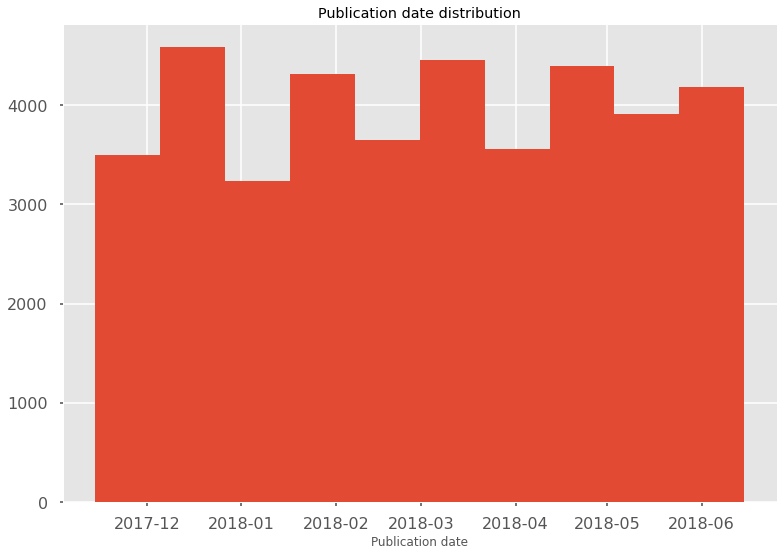

In [0]:
df.publishedAt.hist()
plt.xlabel('Publication date')
plt.title('Publication date distribution');

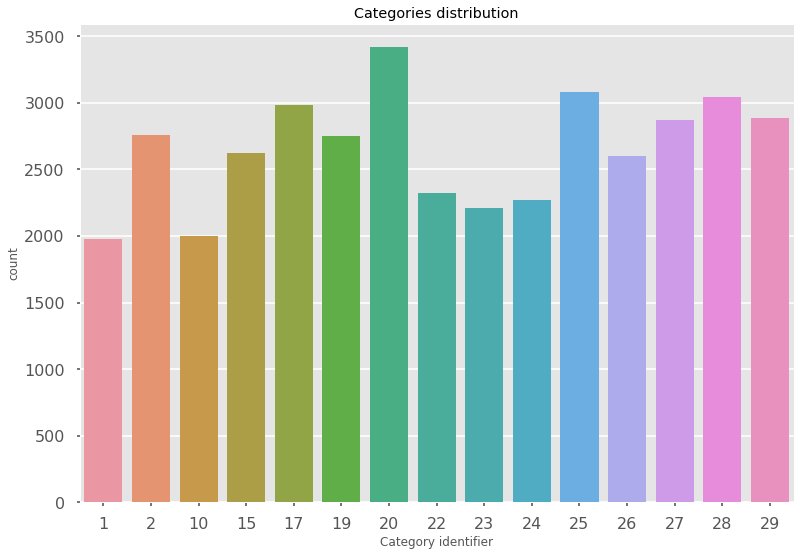

In [0]:
df.categoryId = df.categoryId.astype(int)
sns.countplot(df.categoryId)
plt.xlabel('Category identifier');
plt.title('Categories distribution');

The data aquisition technique determines that data is evenly distributed. The lack of category number 43 is the rseult of lack of data obtained by API for this category.

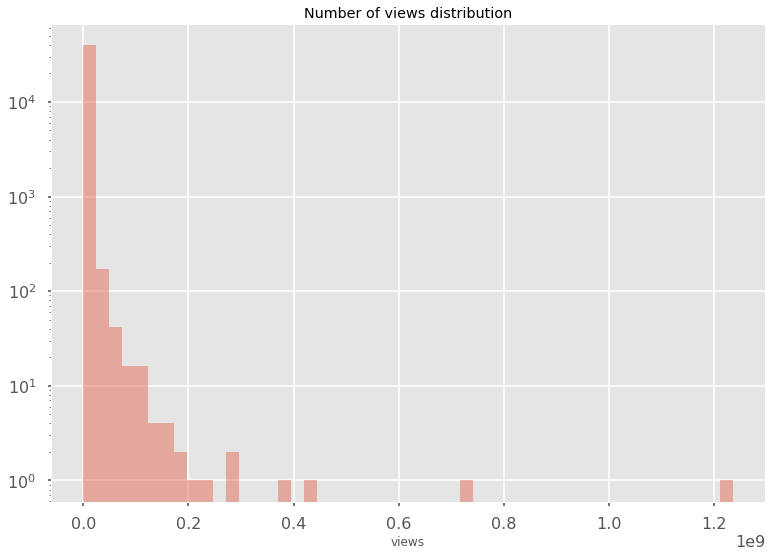

In [0]:
ax = sns.distplot(df.views, kde=False)
ax.set_yscale('log')
ax.set_title('Number of views distribution');

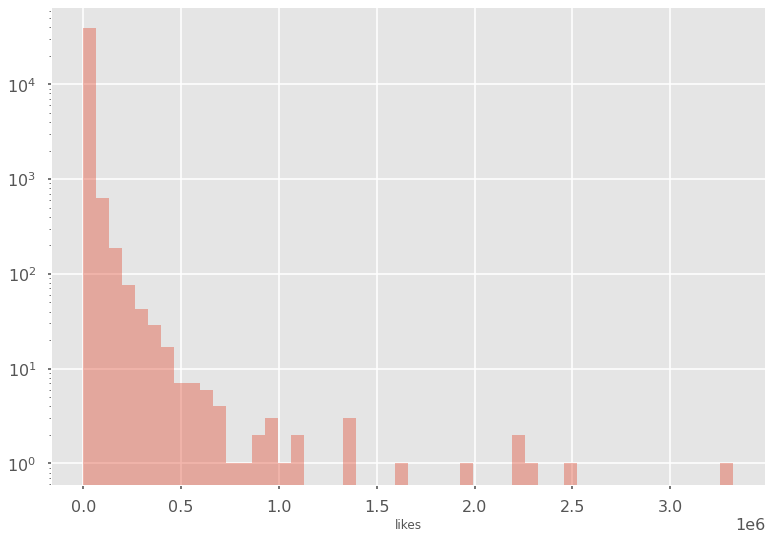

In [0]:
ax = sns.distplot(df.likes, kde=False);
ax.set_yscale('log');

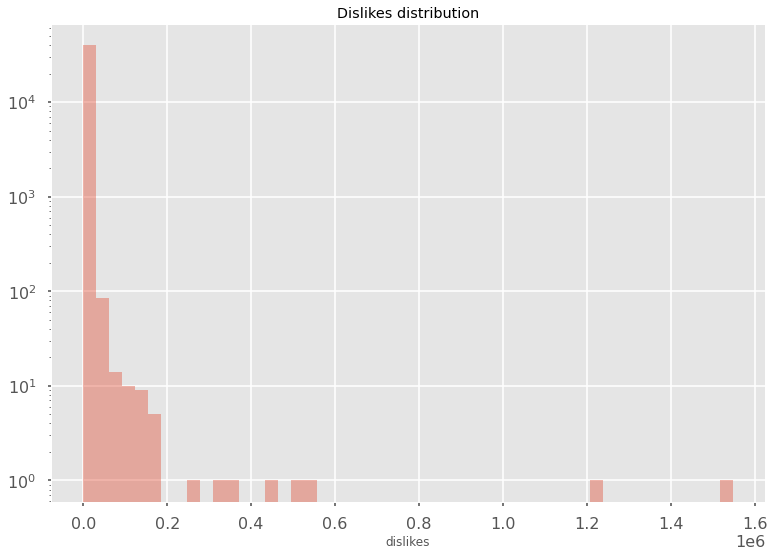

In [0]:
ax = sns.distplot(df.dislikes, kde=False)
ax.set_title('Dislikes distribution')
ax.set_yscale('log');

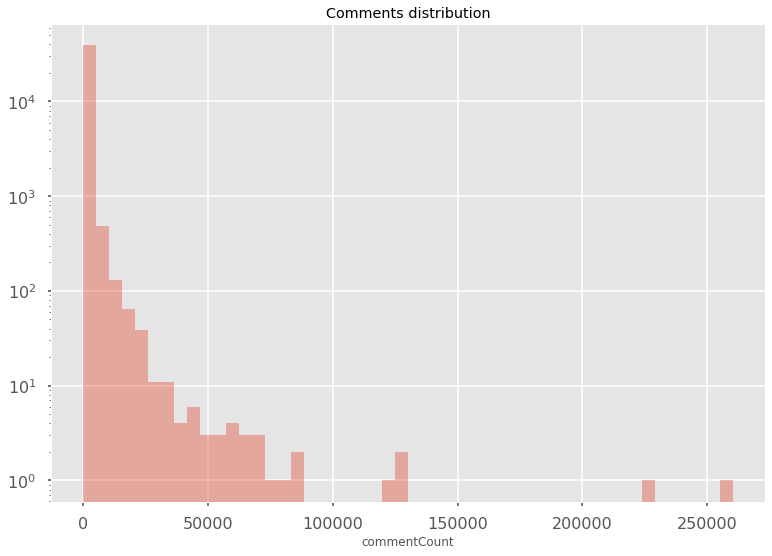

In [0]:
ax = sns.distplot(df.commentCount, kde=False);
ax.set_title('Comments distribution');
ax.set_yscale('log');

Views, ratings and comments distribution is natural consequence of excluding trending videos - there are only a few extremely viewed, liked and commented videos.